# Liver Series - Part 3
In this third installment of our series we will be performing analysis on both categorical and continuous variables. Some of the tests we will use are:
* student t-test
* ANOVA
* Mann-Whitney
* Kruskal-Wallis

In [1]:
# Import the necessary libraries needed

import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import f_oneway
from scipy.stats import mannwhitneyu
from scipy.stats import kruskal

# We only need this library to be able to perform QQ plot
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# We need this additional code (again) to be able to display tables/dataframes in one output.

from IPython.display import display, HTML

CSS = """
.output {
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(CSS))

# What does our dataset look like?

In [3]:
pbc = pd.read_csv('primary biliary cirrhosis RCT mod1.csv')
pbc.head()

,PatientID,DaySurvival,Status,Treatment,AgeYrs,Sex,Ascites,Hepatomegaly,SpiderAngiomata,Edema,Bilirubin,Cholesterol,Albumin,Copper,ALP,AST,Triglyceride,Platelet,Protime,HistologyStage
0,1,400,censored,penicillamine,58.77,F,yes,yes,yes,present,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,dead,penicillamine,56.45,F,no,yes,yes,absent,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,censored,penicillamine,70.07,M,no,no,no,diurese,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,censored,penicillamine,54.74,F,no,yes,yes,diurese,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,transplant,placebo,38.11,F,no,yes,yes,absent,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


In [4]:
# We will then drop all the null values that coincides with the Treatment variable, 
#just like what we did in Part 2.

pbc = pbc.dropna(subset=['Treatment'])

# Then the remaining variables that still have null values are 
#continuous variables: Cholesterol, Copper, Triglyceride, and Platelet.

pbc['Cholesterol'].fillna(value=pbc['Cholesterol'].mean(), inplace=True)
pbc['Copper'].fillna(value=pbc['Copper'].mean(), inplace=True)
pbc['Triglyceride'].fillna(value=pbc['Triglyceride'].mean(), inplace=True)
pbc['Platelet'].fillna(value=pbc['Platelet'].mean(), inplace=True)

# We will also convert our variable HistologyStage from integer to string
pbc['HistologyStage'] = pbc['HistologyStage'].apply(str)
pbc['HistologyStage'].replace('1.0', 'Stage1', inplace=True)
pbc['HistologyStage'].replace('2.0', 'Stage2', inplace=True)
pbc['HistologyStage'].replace('3.0', 'Stage3', inplace=True)
pbc['HistologyStage'].replace('4.0', 'Stage4', inplace=True)

# Create a subset for the categorical variables

In [5]:
# Histology Stage
Stage1 = pbc[pbc['HistologyStage'] == 'Stage1']
Stage2 = pbc[pbc['HistologyStage'] == 'Stage2']
Stage3 = pbc[pbc['HistologyStage'] == 'Stage3']
Stage4 = pbc[pbc['HistologyStage'] == 'Stage4']

# Hepatomegaly
nohepato = pbc[pbc['Hepatomegaly'] == 'no']
yeshepato = pbc[pbc['Hepatomegaly'] == 'yes']

# Edema
present = pbc[pbc['Edema'] == 'present']
diurese = pbc[pbc['Edema'] == 'diurese']
absent = pbc[pbc['Edema'] == 'absent']

# Censoring Status
dead = pbc[pbc['Status'] == 'dead']
censored = pbc[pbc['Status'] == 'censored']
transplant = pbc[pbc['Status'] == 'transplant']

# Spider angiomata
nospider = pbc[pbc['SpiderAngiomata'] == 'no']
yesspider = pbc[pbc['SpiderAngiomata'] == 'yes']

# Treatment group
penicillamine = pbc[pbc['Treatment'] == 'penicillamine']
placebo = pbc[pbc['Treatment'] == 'placebo']

# Sex
female = pbc[pbc['Sex'] == 'F']
male = pbc[pbc['Sex'] == 'M']

# Ascites
noascites = pbc[pbc['Ascites'] == 'no']
yesascites = pbc[pbc['Ascites'] == 'yes']

# Parametric or not, that is the question?
When we did the Part 1 of our series, we are able to visualize our continuous variables. From there, we are able to know which among them has a gaussian curve. Most of them don't have the gaussian distribution, except for  variables: **AgeYrs**, **Platelet** and **Albumin**.
<br>
We will be performing parametric tests on these 3 variables. However, we first need to visualize them in QQ plot to really see if they indeed have gaussian distribution.

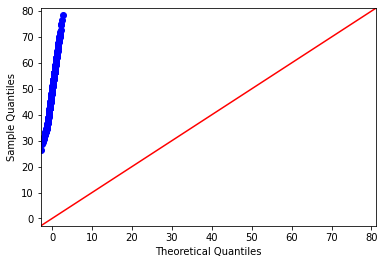

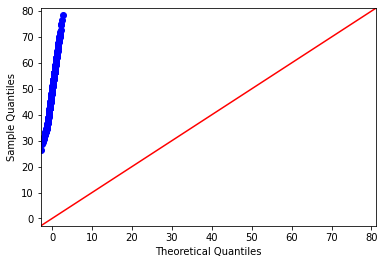

In [6]:
AgeYrs = pbc['AgeYrs']
sm.qqplot(AgeYrs, line='45')

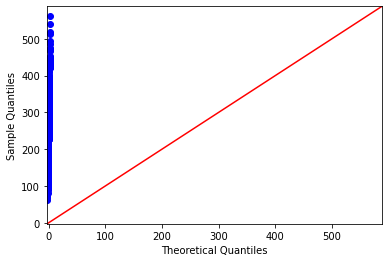

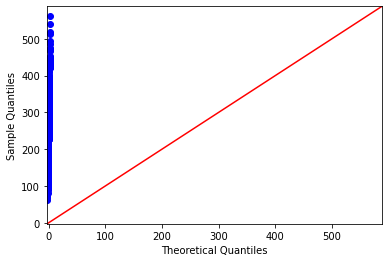

In [7]:
Platelet = pbc['Platelet']
sm.qqplot(Platelet, line='45')

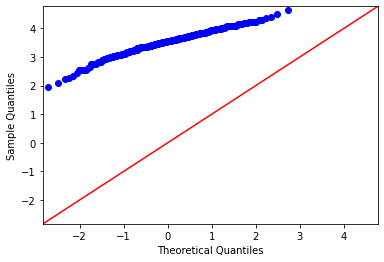

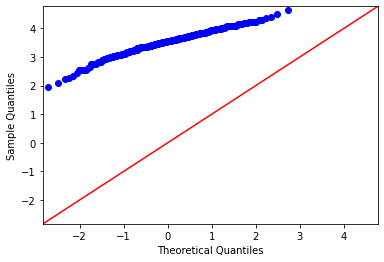

In [8]:
Albumin = pbc['Albumin']
sm.qqplot(Albumin, line='45')

Apparently, even though our variables look like they have gaussian distribution (see Part 1), they didn't pass our QQ plot However, we will do both parametric and non-parametric tests on these variables just to compare.

# DaySurvival - Kruskal-Wallis test
* $H_0$: The median day survival of the groups are equal.
* $H_0$: $\tilde{x}_{1}$ = $\tilde{x}_{2}$ = $\tilde{x}_{n}$
* $H_1$: The median day survival of one or more groups are not equal.
* $\alpha = 0.05$

## Edema
* $H_0$: The median day survival of the groups with edema, diuresed edema, and absent edema are equal.
* $H_0$: $\widetilde{x}_{present}$ = $\widetilde{x}_{diurese}$ = $\widetilde{x}_{absent}$
* $H_1$: At least one of the median of the group is not equal.
* $\alpha = 0.05$

In [9]:
# Subset array
presentDS = present['DaySurvival']
diureseDS = diurese['DaySurvival']
absentDS = absent['DaySurvival']

# Perform the Kruskal-Wallis test
KWH, pval = kruskal(presentDS, diureseDS, absentDS)

result = pd.DataFrame([KWH, pval], 
                      index=['KWH statistics', 'p-value'],
                      columns=['Result'])
result

,Result
KWH statistics,4.155500e+01
p-value,9.472097e-10


### Result and Interpretation
Our result revealed that:
<br>
p-value = 9.47e-10 $<$ $\alpha = 0.05$
<br>
We will **reject** our null hypothesis. At least one in our groups' median is not equal.

## Censoring Status
* $H_0$: The median of the day survival of with status dead, transplant, censored are equal.
* $H_0$: $\widetilde{x}_{dead}$ = $\widetilde{x}_{transplant}$ = $\widetilde{x}_{status}$
* $H_1$: At least one of the median of the group is not equal.
* $\alpha = 0.05$

In [10]:
# Subset array
deadDS = dead['DaySurvival']
censoredDS = censored['DaySurvival']
transplantDS = transplant['DaySurvival']

# Perform the Kruskal-Wallis test
KWH, pval = kruskal(deadDS, censoredDS, transplantDS)

result = pd.DataFrame([KWH, pval], 
                      index=['KWH statistics', 'p-value'],
                      columns=['Result'])
result

,Result
KWH statistics,6.367708e+01
p-value,1.488323e-14


### Result and Interpretation
Our result revealed that:
<br>
p-value = 1.488e-14 $<$ $\alpha = 0.05$
<br>
We will **reject** our null hypothesis. At least one of the groups' median is not equal.

## Histology Stage
* $H_0$: The median of the day survival of the groups histology stage (Stage 1, 2, 3, 4) are equal.
* $H_0$: $\widetilde{x}_{stg1}$ = $\widetilde{x}_{stg2}$ = $\widetilde{x}_{stg3}$ = $\tilde{x}_{stg4}$
* $H_1$: At least one of the median of the group is not equal.
* $\alpha = 0.05$

In [11]:
# Subset array
Stage1DS = Stage1['DaySurvival']
Stage2DS = Stage2['DaySurvival']
Stage3DS = Stage3['DaySurvival']
Stage4DS = Stage4['DaySurvival']

# Perform the Kruskal-Wallis test
KWH, pval = kruskal(Stage1DS, Stage2DS, Stage3DS, Stage4DS)

result = pd.DataFrame([KWH, pval], 
                      index=['KWH statistics', 'p-value'],
                      columns=['Result'])
result

,Result
KWH statistics,4.912940e+01
p-value,1.224282e-10


### Result and Interpretation
Our result revealed that:
<br>
p-value = 1.22e-10 $<$ $\alpha = 0.05$
<br>
We will **reject** our null hypothesis. At least one of the groups' median is not equal.

# DaySurvival - Mann-Whitney U test
* $H_0$: There is no difference in the day survival between the 2 groups.
* $H_1$: There is a difference in the day survival between the 2 groups.
* $\alpha = 0.05$


## Spider Angiomata
* $H_0$: There is no difference in the day survival between the group with spider angiomata and those without.
* $H_1$: There is a significant difference in the day survival between having or not having spider angiomata.
* $\alpha = 0.05$

In [12]:
# Subset array
nospiderDS = nospider['DaySurvival']
yesspiderDS = yesspider['DaySurvival']

# Perform the Mann-Whitney U test
MWU, pval = mannwhitneyu(yesspiderDS, nospiderDS)

result = pd.DataFrame([MWU, pval], 
                      index=['MWU statistics', 'p-value'],
                      columns=['Result'])
result

,Result
MWU statistics,6594.000000
p-value,0.000001


### Result and Interpretation
Our result revealed that:
<br>
p-value = 0.000001 $<$ $\alpha = 0.05$
<br>
We will **reject** our null hypothesis. There is a significant difference in the day survival between having or not having spider angiomata.

## Hepatomegaly
* $H_0$: There is no difference in the day survival between the group with hepatomegaly and those without.
* $H_1$: There is a significant difference in the day survival between having or not having hepatomegaly.
* $\alpha = 0.05$

In [13]:
# Subset array
nohepatoDS = nohepato['DaySurvival']
yeshepatoDS = yeshepato['DaySurvival']

# Perform the Mann-Whitney U test
MWU, pval = mannwhitneyu(yeshepatoDS, nohepatoDS)

result = pd.DataFrame([MWU, pval], 
                      index=['MWU statistics', 'p-value'],
                      columns=['Result'])
result

,Result
MWU statistics,7.959000e+03
p-value,6.674977e-08


### Result and Interpretation
Our result revealed that:
<br>
p-value = 6.67e-8 $<$ $\alpha = 0.05$
<br>
We will **reject** our null hypothesis. There is a significant difference in the day survival between having or not having hepatomegaly.

## Ascites
* $H_0$: There is no difference in the day survival between the group with ascites and those without.
* $H_1$: There is a significant difference in the day survival between having or not having ascites.
* $\alpha = 0.05$

In [14]:
# Subset array
noascitesDS = noascites['DaySurvival']
yesascitesDS = yesascites['DaySurvival']

# Perform the Mann-Whitney U test
MWU, pval = mannwhitneyu(yesascitesDS, noascitesDS)

result = pd.DataFrame([MWU, pval], 
                      index=['MWU statistics', 'p-value'],
                      columns=['Result'])
result

,Result
MWU statistics,1.133000e+03
p-value,2.252504e-08


### Result and Interpretation
Our result revealed that:
<br>
p-value = 2.25e-8 $<$ $\alpha = 0.05$
<br>
We will **reject** our null hypothesis. There is a significant difference in the day survival between having or not having ascites.

## Sex
* $H_0$: There is no difference in the day survival between male and female.
* $H_1$: There is a significant difference in the day survival between male and female.
* $\alpha = 0.05$

In [15]:
# Subset array
maleDS = male['DaySurvival']
femaleDS = female['DaySurvival']

# Perform the Mann-Whitney U test
MWU, pval = mannwhitneyu(femaleDS, maleDS)

result = pd.DataFrame([MWU, pval], 
                      index=['MWU statistics', 'p-value'],
                      columns=['Result'])
result

,Result
MWU statistics,4529.000000
p-value,0.194521


### Result and Interpretation
Our result revealed that:
<br>
p-value = 0.194521 $>$ $\alpha = 0.05$
<br>
We will **not reject** our null hypothesis. There is no significant difference in the day survival between female and male.

## Treatment group
* $H_0$: There is no difference in the day survival between penicillamine and placebo treatment group.
* $H_1$: There is a significant difference in the day survival between penicillamine and placebo treatment group.
* $\alpha = 0.05$

In [16]:
# Subset array
penicillamineDS = penicillamine['DaySurvival']
placeboDS = placebo['DaySurvival']

# Perform the Mann-Whitney U test
MWU, pval = mannwhitneyu(penicillamineDS, placeboDS)

result = pd.DataFrame([MWU, pval], 
                      index=['MWU statistics', 'p-value'],
                      columns=['Result'])
result

,Result
MWU statistics,11991.500000
p-value,0.413554


### Result and Interpretation
Our result revealed that:
<br>
p-value = 0.413554 $>$ $\alpha = 0.05$
<br>
We will **not reject** our null hypothesis. There is no significant difference in the day survival between penicillamine and placebo treatment group.

# Bilirubin - Kruskal-Wallis test
* $H_0$: The median bilrubin level of the groups are equal.
* $H_0$: $\widetilde{x}_{1}$ = $\widetilde{x}_{2}$ = $\widetilde{x}_{n}$
* $H_1$: The median bilrubin level of one or more groups are not equal.
* $\alpha = 0.05$

## Edema
* $H_0$: The median bilirubin level of the groups with edema, diuresed edema, and absent edema are equal.
* $H_0$: $\widetilde{x}_{present}$ = $\widetilde{x}_{diurese}$ = $\widetilde{x}_{absent}$
* $H_1$: At least one of the groups' median bilirubin level is not equal.
* $\alpha = 0.05$

In [17]:
# Subset array
presentBili = present['Bilirubin']
diureseBili = diurese['Bilirubin']
absentBili = absent['Bilirubin']

# Perform the Kruskal-Wallis test
KWH, pval = kruskal(presentBili, diureseBili, absentBili)

result = pd.DataFrame([KWH, pval], 
                      index=['KWH statistics', 'p-value'],
                      columns=['Result'])
result

,Result
KWH statistics,3.004142e+01
p-value,2.996326e-07


### Result and Interpretation
Our result revealed that:
<br>
p-value = 2.996e-7 $<$ $\alpha = 0.05$
<br>
We will **reject** our null hypothesis. At least one in our groups' median bilirubin is not equal.

## Censoring Status
* $H_0$: The median bilirubin level of with status dead, transplant, censored are equal.
* $H_0$: $\widetilde{x}_{dead}$ = $\widetilde{x}_{transplant}$ = $\widetilde{x}_{status}$
* $H_1$: At least one of the groups' median bilirubin level is not equal.
* $\alpha = 0.05$

In [18]:
# Subset array
deadBili = dead['Bilirubin']
censoredBili = censored['Bilirubin']
transplantBili = transplant['Bilirubin']

# Perform the Kruskal-Wallis test
KWH, pval = kruskal(deadBili, censoredBili, transplantBili)

result = pd.DataFrame([KWH, pval], 
                      index=['KWH statistics', 'p-value'],
                      columns=['Result'])
result

,Result
KWH statistics,9.419165e+01
p-value,3.520009e-21


### Result and Interpretation
Our result revealed that:
<br>
p-value = 3.5e-21 $<$ $\alpha = 0.05$
<br>
We will **reject** our null hypothesis. At least one in our groups' median bilirubin is not equal.

## Histology Stage
* $H_0$: The median bilirubin level of the 4 histology stages are equal.
* $H_0$: $\widetilde{x}_{stg1}$ = $\widetilde{x}_{stg2}$ = $\widetilde{x}_{stg3}$ = $\widetilde{x}_{stg4}$
* $H_1$: At least one of the groups' median bilirubin level is not equal.
* $\alpha = 0.05$

In [19]:
# Subset array
St1Bili = Stage1['Bilirubin']
St2Bili = Stage2['Bilirubin']
St3Bili = Stage3['Bilirubin']
St4Bili = Stage4['Bilirubin']

# Perform the Kruskal-Wallis test
KWH, pval = kruskal(St1Bili, St2Bili, St3Bili, St4Bili)

result = pd.DataFrame([KWH, pval], 
                      index=['KWH statistics', 'p-value'],
                      columns=['Result'])
result

,Result
KWH statistics,4.825396e+01
p-value,1.880308e-10


### Result and Interpretation
Our result revealed that:
<br>
p-value = 1.88e-10 $<$ $\alpha = 0.05$
<br>
We will **reject** our null hypothesis. At least one in our groups' median bilirubin is not equal.

# Bilirubin - Mann-Whitney U test
* $H_0$: There is no difference in the bilirubin level between the 2 groups.
* $H_1$: There is a difference in the bilirubin level between the 2 groups.
* $\alpha = 0.05$


## Spider Angiomata
* $H_0$: There is no difference in the bilirubin level between the group with spider angiomata and those without.
* $H_1$: There is a significant difference in the bilirubin level between having or not having spider angiomata.
* $\alpha = 0.05$

In [20]:
# Subset array
nospiderBili = nospider['Bilirubin']
yesspiderBili = yesspider['Bilirubin']

# Perform the Mann-Whitney U test
MWU, pval = mannwhitneyu(yesspiderBili, nospiderBili)

result = pd.DataFrame([MWU, pval], 
                      index=['MWU statistics', 'p-value'],
                      columns=['Result'])
result

,Result
MWU statistics,5.580000e+03
p-value,4.892149e-10


### Result and Interpretation
Our result revealed that:
<br>
p-value = 4.89e-10 $<$ $\alpha = 0.05$
<br>
We will **reject** our null hypothesis. There is a significant difference in the bilirubin level between having or not having spider angiomata.

## Hepatomegaly
* $H_0$: There is no difference in the bilirubin level between the group with hepatomegaly and those without.
* $H_1$: There is a significant difference in the bilirubin level between having or not having hepatomegaly.
* $\alpha = 0.05$

In [21]:
# Subset array
nohepatoBili = nohepato['Bilirubin']
yeshepatoBili = yeshepato['Bilirubin']

# Perform the Mann-Whitney U test
MWU, pval = mannwhitneyu(yeshepatoBili, nohepatoBili)

result = pd.DataFrame([MWU, pval], 
                      index=['MWU statistics', 'p-value'],
                      columns=['Result'])
result

,Result
MWU statistics,6.684500e+03
p-value,3.003010e-12


### Result and Interpretation
Our result revealed that:
<br>
p-value = 3.0e-12 $<$ $\alpha = 0.05$
<br>
We will **reject** our null hypothesis. There is a significant difference in the bilirubin level between having or not having hepatomegaly.

## Ascites
* $H_0$: There is no difference in the bilirubin level between the group with ascites and those without.
* $H_1$: There is a significant difference in the bilirubin level between having or not having ascites.
* $\alpha = 0.05$

In [22]:
# Subset array
noascitesBili = noascites['Bilirubin']
yesascitesBili = yesascites['Bilirubin']

# Perform the Mann-Whitney U test
MWU, pval = mannwhitneyu(noascitesBili, yesascitesBili)

result = pd.DataFrame([MWU, pval], 
                      index=['MWU statistics', 'p-value'],
                      columns=['Result'])
result

,Result
MWU statistics,1.403500e+03
p-value,6.607539e-07


### Result and Interpretation
Our result revealed that:
<br>
p-value = 6.6e-7 $<$ $\alpha = 0.05$
<br>
We will **reject** our null hypothesis. There is a significant difference in the bilirubin level between having or not having ascites.

## Sex
* $H_0$: There is no difference in the bilirubin level between female and male.
* $H_1$: There is a significant difference in the bilirubin level between female and male.
* $\alpha = 0.05$

In [23]:
# Subset array
femaleBili = female['Bilirubin']
maleBili = male['Bilirubin']

# Perform the Mann-Whitney U test
MWU, pval = mannwhitneyu(femaleBili, maleBili)

result = pd.DataFrame([MWU, pval], 
                      index=['MWU statistics', 'p-value'],
                      columns=['Result'])
result

,Result
MWU statistics,3978.500000
p-value,0.025934


### Result and Interpretation
Our result revealed that:
<br>
p-value = 0.0259 $<$ $\alpha = 0.05$
<br>
We will **reject** our null hypothesis. There is a significant difference in the bilirubin level between male and female.

## Treatment group
* $H_0$: There is no difference in the bilirubin level between penicillamine and placebo treatment group.
* $H_1$: There is a significant difference in the bilirubin level between penicillamine and placebo treatment group.
* $\alpha = 0.05$

In [24]:
# Subset array
penicillamineBili = penicillamine['Bilirubin']
placeboBili = placebo['Bilirubin']

# Perform the Mann-Whitney U test
MWU, pval = mannwhitneyu(penicillamineBili, placeboBili)

result = pd.DataFrame([MWU, pval], 
                      index=['MWU statistics', 'p-value'],
                      columns=['Result'])
result

,Result
MWU statistics,12007.000000
p-value,0.421088


### Result and Interpretation
Our result revealed that:
<br>
p-value = 0.42 $>$ $\alpha = 0.05$
<br>
We will **not reject** our null hypothesis. There is no significant difference in the bilirubin level between male and female.

# Protime - Kruskal-Wallis test
* $H_0$: The median protime of the groups are equal.
* $H_0$: $\widetilde{x}_{1}$ = $\widetilde{x}_{2}$ = $\widetilde{x}_{n}$
* $H_1$: The median protime of one or more groups are not equal.
* $\alpha = 0.05$

## Edema
* $H_0$: The median protime of the groups with edema, diuresed edema, and absent edema are equal.
* $H_0$: $\widetilde{x}_{present}$ = $\widetilde{x}_{diurese}$ = $\widetilde{x}_{absent}$
* $H_1$: At least one of the groups' median protime is not equal.
* $\alpha = 0.05$

In [25]:
# Subset array
presentPT = present['Protime']
diuresePT = diurese['Protime']
absentPT = absent['Protime']

# Perform the Kruskal-Wallis test
KWH, pval = kruskal(presentPT, diuresePT, absentPT)

result = pd.DataFrame([KWH, pval], 
                      index=['KWH statistics', 'p-value'],
                      columns=['Result'])
result

,Result
KWH statistics,4.375774e+01
p-value,3.148670e-10


### Result and Interpretation
Our result revealed that:
<br>
p-value = 3.15e-7 $<$ $\alpha = 0.05$
<br>
We will **reject** our null hypothesis. At least one in our groups' median protime is not equal.

## Censoring status
* $H_0$: The median protime of the groups with status dead, censored, and transplant are equal.
* $H_0$: $\widetilde{x}_{dead}$ = $\widetilde{x}_{censored}$ = $\widetilde{x}_{transplant}$
* $H_1$: At least one of the groups' median protime is not equal.
* $\alpha = 0.05$

In [26]:
# Subset array
deadPT = dead['Protime']
censoredPT = censored['Protime']
transplantPT = transplant['Protime']

# Perform the Kruskal-Wallis test
KWH, pval = kruskal(deadPT, censoredPT, transplantPT)

result = pd.DataFrame([KWH, pval], 
                      index=['KWH statistics', 'p-value'],
                      columns=['Result'])
result

,Result
KWH statistics,6.457980e+01
p-value,9.477105e-15


### Result and Interpretation
Our result revealed that:
<br>
p-value = 9.477e-15 $<$ $\alpha = 0.05$
<br>
We will **reject** our null hypothesis. At least one in our groups' median protime is not equal.

## Histology Stage
* $H_0$: The median protime of the histology staging groups are equal.
* $H_0$: $\widetilde{x}_{stg1}$ = $\widetilde{x}_{stg2}$ = $\widetilde{x}_{stg3}$ = $\widetilde{x}_{stg4}$
* $H_1$: At least one of the histology staging  groups' median protime is not equal.
* $\alpha = 0.05$

In [27]:
# Subset array
St1pt = Stage1['Protime']
St2pt = Stage2['Protime']
St3pt = Stage3['Protime']
St4pt = Stage4['Protime']

# Perform the Kruskal-Wallis test
KWH, pval = kruskal(St1pt, St2pt, St3pt, St4pt)

result = pd.DataFrame([KWH, pval], 
                      index=['KWH statistics', 'p-value'],
                      columns=['Result'])
result

,Result
KWH statistics,4.289685e+01
p-value,2.588280e-09


### Result and Interpretation
Our result revealed that:
<br>
p-value = 2.588e-9 $<$ $\alpha = 0.05$
<br>
We will **reject** our null hypothesis. At least one in our groups' median protime is not equal.

# Protime - Mann-Whitney U test
* $H_0$: There is no difference in the protime between the 2 groups.
* $H_1$: There is a difference in the protime between the 2 groups.
* $\alpha = 0.05$


## Spider Angiomata
* $H_0$: There is no difference in the protime between the group with spider angiomata and those without.
* $H_1$: There is a significant difference in protime between having or not having spider angiomata.
* $\alpha = 0.05$

In [28]:
# Subset array
nospiderPT = nospider['Protime']
yesspiderPT = yesspider['Protime']

# Perform the Mann-Whitney U test
MWU, pval = mannwhitneyu(yesspiderPT, nospiderPT)

result = pd.DataFrame([MWU, pval], 
                      index=['MWU statistics', 'p-value'],
                      columns=['Result'])
result

,Result
MWU statistics,6888.000000
p-value,0.000008


### Result and Interpretation
Our result revealed that:
<br>
p-value = 0.000008 $<$ $\alpha = 0.05$
<br>
We will **reject** our null hypothesis. There is a significant difference in the protime between having or not having spider angiomata.

## Hepatomegaly
* $H_0$: There is no difference in the protime between the group with hepatomegaly and those without.
* $H_1$: There is a significant difference in protime between having or not having hepatomegaly.
* $\alpha = 0.05$

In [29]:
# Subset array
nohepatoPT = nohepato['Protime']
yeshepatoPT = yeshepato['Protime']

# Perform the Mann-Whitney U test
MWU, pval = mannwhitneyu(yeshepatoPT, nohepatoPT)

result = pd.DataFrame([MWU, pval], 
                      index=['MWU statistics', 'p-value'],
                      columns=['Result'])
result

,Result
MWU statistics,9062.500000
p-value,0.000049


### Result and Interpretation
Our result revealed that:
<br>
p-value = 0.000049 $<$ $\alpha = 0.05$
<br>
We will **reject** our null hypothesis. There is a significant difference in the protime between having or not having hepatomegaly.

## Ascites
* $H_0$: There is no difference in the protime between the group with ascites and those without.
* $H_1$: There is a significant difference in protime between having or not having ascites.
* $\alpha = 0.05$

In [30]:
# Subset array
noascitesPT = noascites['Protime']
yesascitesPT = yesascites['Protime']

# Perform the Mann-Whitney U test
MWU, pval = mannwhitneyu(yesascitesPT, noascitesPT)

result = pd.DataFrame([MWU, pval], 
                      index=['MWU statistics', 'p-value'],
                      columns=['Result'])
result

,Result
MWU statistics,1.103000e+03
p-value,1.448238e-08


### Result and Interpretation
Our result revealed that:
<br>
p-value = 1.448e-8 $<$ $\alpha = 0.05$
<br>
We will **reject** our null hypothesis. There is a significant difference in the protime between having or not having ascites.

## Sex
* $H_0$: There is no difference in the protime between female and male.
* $H_1$: There is a significant difference in protime between female and male.
* $\alpha = 0.05$

In [31]:
# Subset array
femalePT = female['Protime']
malePT = male['Protime']

# Perform the Mann-Whitney U test
MWU, pval = mannwhitneyu(femalePT, malePT)

result = pd.DataFrame([MWU, pval], 
                      index=['MWU statistics', 'p-value'],
                      columns=['Result'])
result

,Result
MWU statistics,3820.000000
p-value,0.012005


### Result and Interpretation
Our result revealed that:
<br>
p-value = 0.012005 $<$ $\alpha = 0.05$
<br>
We will **reject** our null hypothesis. There is a significant difference in the protime between male and female.

## Treatment group
* $H_0$: There is no difference in the protime between penicillamine and placebo treatment group.
* $H_1$: There is a significant difference in protime between penicillamine and placebo treatment group.
* $\alpha = 0.05$

In [32]:
# Subset array
penicillaminePT = penicillamine['Protime']
placeboPT = placebo['Protime']

# Perform the Mann-Whitney U test
MWU, pval = mannwhitneyu(penicillaminePT, placeboPT)

result = pd.DataFrame([MWU, pval], 
                      index=['MWU statistics', 'p-value'],
                      columns=['Result'])
result

,Result
MWU statistics,11735.000000
p-value,0.294227


### Result and Interpretation
Our result revealed that:
<br>
p-value = 0.294227 $>$ $\alpha = 0.05$
<br>
We will **not reject** our null hypothesis. There is no significant difference in the protime between penicillamine and placebo treatment group.

# Triglyceride - Kruskal-Wallis test
* $H_0$: The median triglyceride level of the groups are equal.
* $H_0$: $\widetilde{x}_{1}$ = $\widetilde{x}_{2}$ = $\widetilde{x}_{n}$
* $H_1$: The median triglyceride level of one or more groups are not equal.
* $\alpha = 0.05$

## Edema
* $H_0$: The median triglyceride level of the groups with edema, diuresed edema, and absent edema are equal.
* $H_0$: $\widetilde{x}_{present}$ = $\widetilde{x}_{diurese}$ = $\widetilde{x}_{absent}$
* $H_1$: At least one of the groups' median triglyceride level is not equal.
* $\alpha = 0.05$

In [33]:
# Subset array
presentTG = present['Triglyceride']
diureseTG = diurese['Triglyceride']
absentTG = absent['Triglyceride']

# Perform the Kruskal-Wallis test
KWH, pval = kruskal(presentTG, diureseTG, absentTG)

result = pd.DataFrame([KWH, pval], 
                      index=['KWH statistics', 'p-value'],
                      columns=['Result'])
result

,Result
KWH statistics,0.821094
p-value,0.663287


### Result and Interpretation
Our result revealed that:
<br>
p-value = 0.663287 $>$ $\alpha = 0.05$
<br>
We will **not reject** our null hypothesis. There is no significant difference in the median triglyceride level among the edema groups. Or, the median triglyceride level among the groups are equal.

## Censoring status
* $H_0$: The median triglyceride level of the groups with status dead, transplant, and censored are equal.
* $H_0$: $\widetilde{x}_{dead}$ = $\widetilde{x}_{censored}$ = $\widetilde{x}_{transplant}$
* $H_1$: At least one of the groups' median triglyceride level is not equal.
* $\alpha = 0.05$

In [34]:
# Subset array
deadTG = dead['Triglyceride']
censoredTG = censored['Triglyceride']
transplantTG = transplant['Triglyceride']

# Perform the Kruskal-Wallis test
KWH, pval = kruskal(deadTG, censoredTG, transplantTG)

result = pd.DataFrame([KWH, pval], 
                      index=['KWH statistics', 'p-value'],
                      columns=['Result'])
result

,Result
KWH statistics,10.392190
p-value,0.005538


### Result and Interpretation
Our result revealed that:
<br>
p-value = 0.005538 $<$ $\alpha = 0.05$
<br>
We will **reject** our null hypothesis. At least one group's median triglyceride level is not equal.

## Histology stage
* $H_0$: The median triglyceride level of the histology stage groups are equal.
* $H_0$: $\widetilde{x}_{stg1}$ = $\widetilde{x}_{stg2}$ = $\widetilde{x}_{stg3}$ = $\widetilde{x}_{stg4}$
* $H_1$: At least one of the groups' median triglyceride level is not equal.
* $\alpha = 0.05$

In [35]:
# Subset array
St1TG = Stage1['Triglyceride']
St2TG = Stage2['Triglyceride']
St3TG = Stage3['Triglyceride']
St4TG = Stage4['Triglyceride']

# Perform the Kruskal-Wallis test
KWH, pval = kruskal(St1TG, St2TG, St3TG, St4TG)

result = pd.DataFrame([KWH, pval], 
                      index=['KWH statistics', 'p-value'],
                      columns=['Result'])
result

,Result
KWH statistics,9.896002
p-value,0.019471


### Result and Interpretation
Our result revealed that:
<br>
p-value = 0.019471 $<$ $\alpha = 0.05$
<br>
We will **reject** our null hypothesis. At least one groups median triglyceride level is not equal.

# Triglyceride - Mann-Whitney U test
* $H_0$: There is no difference in the triglyceride level between the 2 groups.
* $H_1$: There is a difference in the triglyceride level between the 2 groups.
* $\alpha = 0.05$


## Spider Angiomata
* $H_0$: There is no difference in the triglyceride level between the group with spider angiomata and those without.
* $H_1$: There is a significant difference in triglyceride levelbetween having or not having spider angiomata.
* $\alpha = 0.05$

In [36]:
# Subset array
nospiderTG = nospider['Triglyceride']
yesspiderTG = yesspider['Triglyceride']

# Perform the Mann-Whitney U test
MWU, pval = mannwhitneyu(yesspiderTG, nospiderTG)

result = pd.DataFrame([MWU, pval], 
                      index=['MWU statistics', 'p-value'],
                      columns=['Result'])
result

,Result
MWU statistics,9896.000000
p-value,0.448449


### Result and Interpretation
Our result revealed that:
<br>
p-value = 0.448 $>$ $\alpha = 0.05$
<br>
We will **not reject** our null hypothesis. There is no significant difference in the triglyceride level between having or not having spider angiomata.

## Hepatomegaly
* $H_0$: There is no difference in the triglyceride level between the group with hepatomegaly and those without.
* $H_1$: There is a significant difference in triglyceride level between having or not having hepatomegaly.
* $\alpha = 0.05$

In [37]:
# Subset array
nohepatoTG = nohepato['Triglyceride']
yeshepatoTG = yeshepato['Triglyceride']

# Perform the Mann-Whitney U test
MWU, pval = mannwhitneyu(nohepatoTG, yeshepatoTG)

result = pd.DataFrame([MWU, pval], 
                      index=['MWU statistics', 'p-value'],
                      columns=['Result'])
result

,Result
MWU statistics,10010.500000
p-value,0.003472


### Result and Interpretation
Our result revealed that:
<br>
p-value = 0.003472 $<$ $\alpha = 0.05$
<br>
We will **reject** our null hypothesis. There is a significant difference in the triglyceride level between having or not having hepatomegaly.

## Ascites
* $H_0$: There is no difference in the triglyceride level between the group with ascites and those without.
* $H_1$: There is a significant difference in triglyceride level between having or not having ascites.
* $\alpha = 0.05$

In [38]:
# Subset array
noascitesTG = noascites['Triglyceride']
yesascitesTG = yesascites['Triglyceride']

# Perform the Mann-Whitney U test
MWU, pval = mannwhitneyu(noascitesTG, yesascitesTG)

result = pd.DataFrame([MWU, pval], 
                      index=['MWU statistics', 'p-value'],
                      columns=['Result'])
result

,Result
MWU statistics,2473.500000
p-value,0.010337


### Result and Interpretation
Our result revealed that:
<br>
p-value = 0.010337 $<$ $\alpha = 0.05$
<br>
We will **reject** our null hypothesis. There is a significant difference in the triglyceride level between having or not having ascites.

## Sex
* $H_0$: There is no difference in the triglyceride level between female and male.
* $H_1$: There is a significant difference in triglyceride level between female and male.
* $\alpha = 0.05$

In [39]:
# Subset array
femaleTG = female['Triglyceride']
maleTG = male['Triglyceride']

# Perform the Mann-Whitney U test
MWU, pval = mannwhitneyu(femaleTG, maleTG)

result = pd.DataFrame([MWU, pval], 
                      index=['MWU statistics', 'p-value'],
                      columns=['Result'])
result

,Result
MWU statistics,4179.500000
p-value,0.060734


### Result and Interpretation
Our result revealed that:
<br>
p-value = 0.060734 $>$ $\alpha = 0.05$
<br>
We will **not reject** our null hypothesis. There is no significant difference in the triglyceride level between female and male.

## Treatment group
* $H_0$: There is no difference in the triglyceride level between penicillamine and placebo group.
* $H_1$: There is a significant difference in triglyceride level between penicillamine and placebo group.
* $\alpha = 0.05$

In [40]:
# Subset array
penicillamineTG = penicillamine['Triglyceride']
placeboTG = placebo['Triglyceride']

# Perform the Mann-Whitney U test
MWU, pval = mannwhitneyu(penicillamineTG, placeboTG)

result = pd.DataFrame([MWU, pval], 
                      index=['MWU statistics', 'p-value'],
                      columns=['Result'])
result

,Result
MWU statistics,11436.000000
p-value,0.179794


### Result and Interpretation
Our result revealed that:
<br>
p-value = 0.179794 $>$ $\alpha = 0.05$
<br>
We will **not reject** our null hypothesis. There is no significant difference in the triglyceride level between penicillamine and placebo group.

# AST - Kruskal-Wallis test
* $H_0$: The median aspartate aminotransferase level of the groups are equal.
* $H_0$: $\widetilde{x}_{1}$ = $\widetilde{x}_{2}$ = $\widetilde{x}_{n}$
* $H_1$: The median aspartate aminotransferase level of one or more groups are not equal.
* $\alpha = 0.05$

## Edema
* $H_0$: The median AST level of the groups with edema, diuresed edema, and absent edema are equal.
* $H_0$: $\widetilde{x}_{present}$ = $\widetilde{x}_{diurese}$ = $\widetilde{x}_{absent}$
* $H_1$: At least one of the groups' median AST level is not equal.
* $\alpha = 0.05$

In [41]:
# Subset array
presentAST = present['AST']
diureseAST = diurese['AST']
absentAST = absent['AST']

# Perform the Kruskal-Wallis test
KWH, pval = kruskal(presentAST, diureseAST, absentAST)

result = pd.DataFrame([KWH, pval], 
                      index=['KWH statistics', 'p-value'],
                      columns=['Result'])
result

,Result
KWH statistics,4.735805
p-value,0.093677


### Result and Interpretation
Our result revealed that:
<br>
p-value = 0.093677 $>$ $\alpha = 0.05$
<br>
We will **not reject** our null hypothesis. There is no significant difference in the median AST level among the edema groups. Or, the median AST level among the groups are equal.

## Censoring status
* $H_0$: The median AST level of the groups with status dead, transplant, and censored are equal.
* $H_0$: $\widetilde{x}_{dead}$ = $\widetilde{x}_{censored}$ = $\widetilde{x}_{transplant}$
* $H_1$: At least one of the groups' median AST level is not equal.
* $\alpha = 0.05$

In [42]:
# Subset array
deadAST = dead['AST']
censoredAST = censored['AST']
transplantAST = transplant['AST']

# Perform the Kruskal-Wallis test
KWH, pval = kruskal(deadAST, censoredAST, transplantAST)

result = pd.DataFrame([KWH, pval], 
                      index=['KWH statistics', 'p-value'],
                      columns=['Result'])
result

,Result
KWH statistics,3.526612e+01
p-value,2.198163e-08


### Result and Interpretation
Our result revealed that:
<br>
p-value = 2.198e-8 $<$ $\alpha = 0.05$
<br>
We will **reject** our null hypothesis. At least one of the group's median AST is not equal.

## Histology stage
* $H_0$: The median AST level of the histology stage groups are equal.
* $H_0$: $\widetilde{x}_{stg1}$ = $\widetilde{x}_{stg2}$ = $\widetilde{x}_{stg3}$ = $\widetilde{x}_{stg4}$
* $H_1$: At least one of the groups' median AST level is not equal.
* $\alpha = 0.05$

In [43]:
# Subset array
St1AST = Stage1['AST']
St2AST = Stage2['AST']
St3AST = Stage3['AST']
St4AST = Stage4['AST']

# Perform the Kruskal-Wallis test
KWH, pval = kruskal(St1AST, St2AST, St3AST, St4AST)

result = pd.DataFrame([KWH, pval], 
                      index=['KWH statistics', 'p-value'],
                      columns=['Result'])
result

,Result
KWH statistics,16.107418
p-value,0.001078


### Result and Interpretation
Our result revealed that:
<br>
p-value = 0.001078 $<$ $\alpha = 0.05$
<br>
We will **reject** our null hypothesis. At least one of the group's median AST is not equal.

# AST - Mann-Whitney U test
* $H_0$: There is no difference in the aspartate aminotransferase level between the 2 groups.
* $H_1$: There is a difference in the aspartate aminotransferase level between the 2 groups.
* $\alpha = 0.05$


## Spider Angiomata
* $H_0$: There is no difference in the AST level between the group with spider angiomata and those without.
* $H_1$: There is a significant difference in AST level between having or not having spider angiomata.
* $\alpha = 0.05$

In [44]:
# Subset array
nospiderAST = nospider['AST']
yesspiderAST = yesspider['AST']

# Perform the Mann-Whitney U test
MWU, pval = mannwhitneyu(nospiderAST, yesspiderAST)

result = pd.DataFrame([MWU, pval], 
                      index=['MWU statistics', 'p-value'],
                      columns=['Result'])
result

,Result
MWU statistics,8019.500000
p-value,0.003176


### Result and Interpretation
Our result revealed that:
<br>
p-value = 0.003176 $<$ $\alpha = 0.05$
<br>
We will **reject** our null hypothesis. There is a significant difference in the AST level between having or not having spider angiomata.

## Hepatomegaly
* $H_0$: There is no difference in the AST level between the group with hepatomegaly and those without.
* $H_1$: There is a significant difference in AST level between having or not having hepatomegaly.
* $\alpha = 0.05$

In [45]:
# Subset array
nohepatoAST = nohepato['AST']
yeshepatoAST = yeshepato['AST']

# Perform the Mann-Whitney U test
MWU, pval = mannwhitneyu(nohepatoAST, yeshepatoAST)

result = pd.DataFrame([MWU, pval], 
                      index=['MWU statistics', 'p-value'],
                      columns=['Result'])
result

,Result
MWU statistics,9883.000000
p-value,0.002129


### Result and Interpretation
Our result revealed that:
<br>
p-value = 0.002129 $<$ $\alpha = 0.05$
<br>
We will **reject** our null hypothesis. There is a significant difference in the AST level between having or not having hepatomegaly.

## Ascites
* $H_0$: There is no difference in the AST level between the group with ascites and those without.
* $H_1$: There is a significant difference in AST level between having or not having ascites.
* $\alpha = 0.05$

In [46]:
# Subset array
noascitesAST = noascites['AST']
yesascitesAST = yesascites['AST']

# Perform the Mann-Whitney U test
MWU, pval = mannwhitneyu(noascitesAST, yesascitesAST)

result = pd.DataFrame([MWU, pval], 
                      index=['MWU statistics', 'p-value'],
                      columns=['Result'])
result

,Result
MWU statistics,2823.50000
p-value,0.06831


### Result and Interpretation
Our result revealed that:
<br>
p-value = 0.06831 $>$ $\alpha = 0.05$
<br>
We will **not reject** our null hypothesis. There is no significant difference in the AST level between having or not having ascites.

## Sex
* $H_0$: There is no difference in the AST level between female and male.
* $H_1$: There is a significant difference in AST level between female and male.
* $\alpha = 0.05$

In [47]:
# Subset array
femaleAST = female['AST']
maleAST = male['AST']

# Perform the Mann-Whitney U test
MWU, pval = mannwhitneyu(femaleAST, maleAST)

result = pd.DataFrame([MWU, pval],
                      index=['MWU statistics', 'p-value'],
                      columns=['Result'])
result

,Result
MWU statistics,4784.00000
p-value,0.35925


### Result and Interpretation
Our result revealed that:
<br>
p-value = 0.35925 $>$ $\alpha = 0.05$
<br>
We will **not reject** our null hypothesis. There is no significant difference in the AST level between male and female.

## Treatment group
* $H_0$: There is no difference in the AST level between penicillamine and placebo treatment group.
* $H_1$: There is a significant difference in AST level between penicillamine and placebo treatment group.
* $\alpha = 0.05$

In [48]:
# Subset array
penicillamineAST = penicillamine['AST']
placeboAST = placebo['AST']

# Perform the Mann-Whitney U test
MWU, pval = mannwhitneyu(penicillamineAST, placeboAST)

result = pd.DataFrame([MWU, pval],
                      index=['MWU statistics', 'p-value'],
                      columns=['Result'])
result

,Result
MWU statistics,11576.000000
p-value,0.229652


### Result and Interpretation
Our result revealed that:
<br>
p-value = 0.229652 $>$ $\alpha = 0.05$
<br>
We will **not reject** our null hypothesis. There is no significant difference in the AST level between between penicillamine and placebo treatment group.

# ALP - Kruskal-Wallis test
* $H_0$: The median alkaline phosphatase level of the groups are equal.
* $H_0$: $\widetilde{x}_{1}$ = $\widetilde{x}_{2}$ = $\widetilde{x}_{n}$
* $H_1$: The median alkaline phosphatase level of one or more groups are not equal.
* $\alpha = 0.05$

## Edema
* $H_0$: The median ALP level of the groups with edema, diuresed edema, and absent edema are equal.
* $H_0$: $\widetilde{x}_{present}$ = $\widetilde{x}_{diurese}$ = $\widetilde{x}_{absent}$
* $H_1$: At least one of the groups' median ALP level is not equal.
* $\alpha = 0.05$

In [49]:
# Subset array
presentALP = present['ALP']
diureseALP = diurese['ALP']
absentALP = absent['ALP']

# Perform the Kruskal-Wallis test
KWH, pval = kruskal(presentALP, diureseALP, absentALP)

result = pd.DataFrame([KWH, pval], 
                      index=['KWH statistics', 'p-value'],
                      columns=['Result'])
result

,Result
KWH statistics,1.434058
p-value,0.488200


### Result and Interpretation
Our result revealed that:
<br>
p-value = 0.488200 $>$ $\alpha = 0.05$
<br>
We will **not reject** our null hypothesis. There is no significant difference in the median ALP level among the edema groups. Or, the median AST level among the groups are equal.

## Censoring status
* $H_0$: The median ALP level of the groups with status dead, transplant, and censored are equal.
* $H_0$: $\widetilde{x}_{dead}$ = $\widetilde{x}_{censored}$ = $\widetilde{x}_{transplant}$
* $H_1$: At least one of the groups' median ALP level is not equal.
* $\alpha = 0.05$

In [50]:
# Subset array
deadALP = dead['ALP']
censoredALP = censored['ALP']
transplantALP = transplant['ALP']

# Perform the Kruskal-Wallis test
KWH, pval = kruskal(deadALP, censoredALP, transplantALP)

result = pd.DataFrame([KWH, pval], 
                      index=['KWH statistics', 'p-value'],
                      columns=['Result'])
result

,Result
KWH statistics,22.765818
p-value,0.000011


### Result and Interpretation
Our result revealed that:
<br>
p-value = 0.000011 $<$ $\alpha = 0.05$
<br>
We will **reject** our null hypothesis. At least one of the group's median ALP is not equal.

## Histology stage
* $H_0$: The median ALP level of the histology stage groups are equal.
* $H_0$: $\widetilde{x}_{stg1}$ = $\widetilde{x}_{stg2}$ = $\widetilde{x}_{stg3}$ = $\widetilde{x}_{stg4}$
* $H_1$: At least one of the groups' median ALP level is not equal.
* $\alpha = 0.05$

In [51]:
# Subset array
St1ALP = Stage1['ALP']
St2ALP = Stage2['ALP']
St3ALP = Stage3['ALP']
St4ALP = Stage4['ALP']

# Perform the Kruskal-Wallis test
KWH, pval = kruskal(St1ALP, St2ALP, St3ALP, St4ALP)

result = pd.DataFrame([KWH, pval], 
                      index=['KWH statistics', 'p-value'],
                      columns=['Result'])
result

,Result
KWH statistics,7.565153
p-value,0.055908


### Result and Interpretation
Our result revealed that:
<br>
p-value = 0.055908 $>$ $\alpha = 0.05$
<br>
We will **not reject** our null hypothesis. The ALP level among the histology stages are equal.

# ALP - Mann-Whitney U test
* $H_0$: There is no difference in the alkaline phosphatase level between the 2 groups.
* $H_1$: There is a difference in the alkaline phosphatase level between the 2 groups.
* $\alpha = 0.05$


## Spider Angiomata
* $H_0$: There is no difference in the ALP level between the group with spider angiomata and those without.
* $H_1$: There is a significant difference in ALP level between having or not having spider angiomata.
* $\alpha = 0.05$

In [52]:
# Subset array
nospiderALP = nospider['ALP']
yesspiderALP = yesspider['ALP']

# Perform the Mann-Whitney U test
MWU, pval = mannwhitneyu(nospiderALP, yesspiderALP)

result = pd.DataFrame([MWU, pval], 
                      index=['MWU statistics', 'p-value'],
                      columns=['Result'])
result

,Result
MWU statistics,8814.5000
p-value,0.0518


### Result and Interpretation
Our result revealed that:
<br>
p-value = 0.0518 $<$ $\alpha = 0.05$
<br>
We will **reject** our null hypothesis. There is a significant difference in the ALP level between having or not having spider angiomata.

## Hepatomegaly
* $H_0$: There is no difference in the ALP level between the group with hepatomegaly and those without.
* $H_1$: There is a significant difference in ALP level between having or not having hepatomegaly.
* $\alpha = 0.05$

In [53]:
# Subset array
nohepatoALP = nohepato['ALP']
yeshepatoALP = yeshepato['ALP']

# Perform the Mann-Whitney U test
MWU, pval = mannwhitneyu(nohepatoALP, yeshepatoALP)

result = pd.DataFrame([MWU, pval], 
                      index=['MWU statistics', 'p-value'],
                      columns=['Result'])
result

,Result
MWU statistics,9840.500000
p-value,0.001798


### Result and Interpretation
Our result revealed that:
<br>
p-value = 0.001798 $<$ $\alpha = 0.05$
<br>
We will **reject** our null hypothesis. There is a significant difference in the ALP level between having or not having hepatomegaly.

## Ascites
* $H_0$: There is no difference in the ALP level between the group with ascites and those without.
* $H_1$: There is a significant difference in ALP level between having or not having ascites.
* $\alpha = 0.05$

In [54]:
# Subset array
noascitesALP = noascites['ALP']
yesascitesALP = yesascites['ALP']

# Perform the Mann-Whitney U test
MWU, pval = mannwhitneyu(noascitesALP, yesascitesALP)

result = pd.DataFrame([MWU, pval], 
                      index=['MWU statistics', 'p-value'],
                      columns=['Result'])
result

,Result
MWU statistics,3217.500000
p-value,0.287561


### Result and Interpretation
Our result revealed that:
<br>
p-value = 0.287561 $>$ $\alpha = 0.05$
<br>
We will **not reject** our null hypothesis. There is no significant difference in the ALP level between having or not having ascites.

## Sex
* $H_0$: There is no difference in the ALP level between female and male.
* $H_1$: There is a significant difference in ALP level between female and male.
* $\alpha = 0.05$

In [55]:
# Subset array
femaleALP = female['ALP']
maleALP = male['ALP']

# Perform the Mann-Whitney U test
MWU, pval = mannwhitneyu(femaleALP, maleALP)

result = pd.DataFrame([MWU, pval],
                      index=['MWU statistics', 'p-value'],
                      columns=['Result'])
result

,Result
MWU statistics,4933.000000
p-value,0.472985


### Result and Interpretation
Our result revealed that:
<br>
p-value = 0.472985 $>$ $\alpha = 0.05$
<br>
We will **not reject** our null hypothesis. There is no significant difference in the ALP level between male and female.

## Treatment group
* $H_0$: There is no difference in the ALP level between penicillamine and placebo treatment group.
* $H_1$: There is a significant difference in ALP level between penicillamine and placebo treatment group.
* $\alpha = 0.05$

In [56]:
# Subset array
penicillamineALP = penicillamine['ALP']
placeboALP = placebo['ALP']

# Perform the Mann-Whitney U test
MWU, pval = mannwhitneyu(penicillamineALP, placeboALP)

result = pd.DataFrame([MWU, pval],
                      index=['MWU statistics', 'p-value'],
                      columns=['Result'])
result

,Result
MWU statistics,11976.500000
p-value,0.406234


### Result and Interpretation
Our result revealed that:
<br>
p-value = 0.406234 $>$ $\alpha = 0.05$
<br>
We will **not reject** our null hypothesis. There is no significant difference in the ALP level between between penicillamine and placebo treatment group.

# Copper - Kruskal-Wallis test
* $H_0$: The median copper level of the groups are equal.
* $H_0$: $\widetilde{x}_{1}$ = $\widetilde{x}_{2}$ = $\widetilde{x}_{n}$
* $H_1$: The median copper level of one or more groups are not equal.
* $\alpha = 0.05$

## Edema
* $H_0$: The median copper level of the groups with edema, diuresed edema, and absent edema are equal.
* $H_0$: $\widetilde{x}_{present}$ = $\widetilde{x}_{diurese}$ = $\widetilde{x}_{absent}$
* $H_1$: At least one of the groups' median copper level is not equal.
* $\alpha = 0.05$

In [57]:
# Subset array
presentCu = present['Copper']
diureseCu = diurese['Copper']
absentCu = absent['Copper']

# Perform the Kruskal-Wallis test
KWH, pval = kruskal(presentCu, diureseCu, absentCu)

result = pd.DataFrame([KWH, pval], 
                      index=['KWH statistics', 'p-value'],
                      columns=['Result'])
result

,Result
KWH statistics,13.587529
p-value,0.001121


### Result and Interpretation
Our result revealed that:
<br>
p-value = 0.001121 $<$ $\alpha = 0.05$
<br>
We will **reject** our null hypothesis. At least one of the group's median copper is not equal.

## Censoring status
* $H_0$: The median copper level of the groups with status dead, transplant, and censored are equal.
* $H_0$: $\widetilde{x}_{dead}$ = $\widetilde{x}_{censored}$ = $\widetilde{x}_{transplant}$
* $H_1$: At least one of the groups' median copper level is not equal.
* $\alpha = 0.05$

In [58]:
# Subset array
deadCu = dead['Copper']
censoredCu = censored['Copper']
transplantCu = transplant['Copper']

# Perform the Kruskal-Wallis test
KWH, pval = kruskal(deadCu, censoredCu, transplantCu)

result = pd.DataFrame([KWH, pval], 
                      index=['KWH statistics', 'p-value'],
                      columns=['Result'])
result

,Result
KWH statistics,6.238929e+01
p-value,2.833593e-14


### Result and Interpretation
Our result revealed that:
<br>
p-value = 0.000011 $<$ $\alpha = 0.05$
<br>
We will **reject** our null hypothesis. At least one of the group's median copper is not equal.

## Histology stage
* $H_0$: The median copper level of the histology stage groups are equal.
* $H_0$: $\widetilde{x}_{stg1}$ = $\widetilde{x}_{stg2}$ = $\widetilde{x}_{stg3}$ = $\widetilde{x}_{stg4}$
* $H_1$: At least one of the groups' median copper level is not equal.
* $\alpha = 0.05$

In [59]:
# Subset array
St1Cu = Stage1['Copper']
St2Cu = Stage2['Copper']
St3Cu = Stage3['Copper']
St4Cu = Stage4['Copper']

# Perform the Kruskal-Wallis test
KWH, pval = kruskal(St1Cu, St2Cu, St3Cu, St4Cu)

result = pd.DataFrame([KWH, pval], 
                      index=['KWH statistics', 'p-value'],
                      columns=['Result'])
result

,Result
KWH statistics,27.365639
p-value,0.000005


### Result and Interpretation
Our result revealed that:
<br>
p-value = 0.000005 $<$ $\alpha = 0.05$
<br>
We will **reject** our null hypothesis. At least one of the groups' median copper is not equal.

# Copper - Mann-Whitney U test
* $H_0$: There is no difference in the copper level between the 2 groups.
* $H_1$: There is a difference in the copper level between the 2 groups.
* $\alpha = 0.05$


## Spider Angiomata
* $H_0$: There is no difference in the copper level between the group with spider angiomata and those without.
* $H_1$: There is a significant difference in copper level between having or not having spider angiomata.
* $\alpha = 0.05$

In [60]:
# Subset array
nospiderCu = nospider['Copper']
yesspiderCu = yesspider['Copper']

# Perform the Mann-Whitney U test
MWU, pval = mannwhitneyu(nospiderCu, yesspiderCu)

result = pd.DataFrame([MWU, pval], 
                      index=['MWU statistics', 'p-value'],
                      columns=['Result'])
result

,Result
MWU statistics,6578.000000
p-value,0.000001


### Result and Interpretation
Our result revealed that:
<br>
p-value = 0.000001 $<$ $\alpha = 0.05$
<br>
We will **reject** our null hypothesis. There is a significant difference in the copper level between having or not having spider angiomata.

## Hepatomegaly
* $H_0$: There is no difference in the copper level between the group with hepatomegaly and those without.
* $H_1$: There is a significant difference in copper level between having or not having hepatomegaly.
* $\alpha = 0.05$

In [61]:
# Subset array
nohepatoCu = nohepato['Copper']
yeshepatoCu = yeshepato['Copper']

# Perform the Mann-Whitney U test
MWU, pval = mannwhitneyu(nohepatoCu, yeshepatoCu)

result = pd.DataFrame([MWU, pval], 
                      index=['MWU statistics', 'p-value'],
                      columns=['Result'])
result

,Result
MWU statistics,8.231000e+03
p-value,4.054689e-07


### Result and Interpretation
Our result revealed that:
<br>
p-value = 4.05e-7 $<$ $\alpha = 0.05$
<br>
We will **reject** our null hypothesis. There is a significant difference in the copper level between having or not having hepatomegaly.

## Ascites
* $H_0$: There is no difference in the copper level between the group with ascites and those without.
* $H_1$: There is a significant difference in copper level between having or not having ascites.
* $\alpha = 0.05$

In [62]:
# Subset array
noascitesCu = noascites['Copper']
yesascitesCu = yesascites['Copper']

# Perform the Mann-Whitney U test
MWU, pval = mannwhitneyu(noascitesCu, yesascitesCu)

result = pd.DataFrame([MWU, pval], 
                      index=['MWU statistics', 'p-value'],
                      columns=['Result'])
result

,Result
MWU statistics,2013.00000
p-value,0.00034


### Result and Interpretation
Our result revealed that:
<br>
p-value = 0.00034 $<$ $\alpha = 0.05$
<br>
We will **reject** our null hypothesis. There is a significant difference in the copper level between having or not having ascites.

## Sex
* $H_0$: There is no difference in the copper level between female and male.
* $H_1$: There is a significant difference in copper level between female and male.
* $\alpha = 0.05$

In [63]:
# Subset array
femaleCu = female['Copper']
maleCu = male['Copper']

# Perform the Mann-Whitney U test
MWU, pval = mannwhitneyu(femaleCu, maleCu)

result = pd.DataFrame([MWU, pval],
                      index=['MWU statistics', 'p-value'],
                      columns=['Result'])
result

,Result
MWU statistics,2794.50000
p-value,0.00001


### Result and Interpretation
Our result revealed that:
<br>
p-value = 0.00001 $<$ $\alpha = 0.05$
<br>
We will **reject** our null hypothesis. There is a significant difference in the copper level between male and female.

## Treatment group
* $H_0$: There is no difference in the copper level between penicillamine and placebo treatment group.
* $H_1$: There is a significant difference in copper level between penicillamine and placebo treatment group.
* $\alpha = 0.05$

In [64]:
# Subset array
penicillamineCu = penicillamine['Copper']
placeboCu = placebo['Copper']

# Perform the Mann-Whitney U test
MWU, pval = mannwhitneyu(penicillamineCu, placeboCu)

result = pd.DataFrame([MWU, pval],
                      index=['MWU statistics', 'p-value'],
                      columns=['Result'])
result

,Result
MWU statistics,11878.500000
p-value,0.359321


### Result and Interpretation
Our result revealed that:
<br>
p-value = 0.359321 $>$ $\alpha = 0.05$
<br>
We will **not reject** our null hypothesis. There is no significant difference in the copper level between between penicillamine and placebo treatment group.

# Cholesterol - Kruskal-Wallis test
* $H_0$: The median cholesterol level of the groups are equal.
* $H_0$: $\widetilde{x}_{1}$ = $\widetilde{x}_{2}$ = $\widetilde{x}_{n}$
* $H_1$: The median cholesterol level of one or more groups are not equal.
* $\alpha = 0.05$

## Edema
* $H_0$: The median cholesterol level of the groups with edema, diuresed edema, and absent edema are equal.
* $H_0$: $\widetilde{x}_{present}$ = $\widetilde{x}_{diurese}$ = $\widetilde{x}_{absent}$
* $H_1$: At least one of the groups' median cholesterol level is not equal.
* $\alpha = 0.05$

In [65]:
# Subset array
presentChole = present['Cholesterol']
diureseChole = diurese['Cholesterol']
absentChole = absent['Cholesterol']

# Perform the Kruskal-Wallis test
KWH, pval = kruskal(presentChole, diureseChole, absentChole)

result = pd.DataFrame([KWH, pval], 
                      index=['KWH statistics', 'p-value'],
                      columns=['Result'])
result

,Result
KWH statistics,7.364113
p-value,0.025171


### Result and Interpretation
Our result revealed that:
<br>
p-value = 0.025171 $<$ $\alpha = 0.05$
<br>
We will **reject** our null hypothesis. At least one of the group's median cholesterol is not equal.

## Censoring status
* $H_0$: The median cholesterol level of the groups with status dead, transplant, and censored are equal.
* $H_0$: $\widetilde{x}_{dead}$ = $\widetilde{x}_{censored}$ = $\widetilde{x}_{transplant}$
* $H_1$: At least one of the groups' median cholesterol level is not equal.
* $\alpha = 0.05$

In [66]:
# Subset array
deadChole = dead['Cholesterol']
censoredChole = censored['Cholesterol']
transplantChole = transplant['Cholesterol']

# Perform the Kruskal-Wallis test
KWH, pval = kruskal(deadChole, censoredChole, transplantChole)

result = pd.DataFrame([KWH, pval], 
                      index=['KWH statistics', 'p-value'],
                      columns=['Result'])
result

,Result
KWH statistics,11.293087
p-value,0.003530


### Result and Interpretation
Our result revealed that:
<br>
p-value = 0.00353 $<$ $\alpha = 0.05$
<br>
We will **reject** our null hypothesis. At least one of the group's median cholesterol is not equal.

## Histology stage
* $H_0$: The median cholesterol level of the histology stage groups are equal.
* $H_0$: $\widetilde{x}_{stg1}$ = $\widetilde{x}_{stg2}$ = $\widetilde{x}_{stg3}$ = $\widetilde{x}_{stg4}$
* $H_1$: At least one of the groups' median cholesterol level is not equal.
* $\alpha = 0.05$

In [67]:
# Subset array
St1Chole = Stage1['Cholesterol']
St2Chole = Stage2['Cholesterol']
St3Chole = Stage3['Cholesterol']
St4Chole = Stage4['Cholesterol']

# Perform the Kruskal-Wallis test
KWH, pval = kruskal(St1Chole, St2Chole, St3Chole, St4Chole)

result = pd.DataFrame([KWH, pval], 
                      index=['KWH statistics', 'p-value'],
                      columns=['Result'])
result

,Result
KWH statistics,9.780597
p-value,0.020526


### Result and Interpretation
Our result revealed that:
<br>
p-value = 0.020526 $<$ $\alpha = 0.05$
<br>
We will **reject** our null hypothesis. At least one of the groups' median cholesterol is not equal.

# Cholesterol - Mann-Whitney U test
* $H_0$: There is no difference in the cholesterol level between the 2 groups.
* $H_1$: There is a difference in the cholesterol level between the 2 groups.
* $\alpha = 0.05$


## Spider Angiomata
* $H_0$: There is no difference in the cholesterol level between the group with spider angiomata and those without.
* $H_1$: There is a significant difference in cholesterol level between having or not having spider angiomata.
* $\alpha = 0.05$

In [68]:
# Subset array
nospiderChole = nospider['Cholesterol']
yesspiderChole = yesspider['Cholesterol']

# Perform the Mann-Whitney U test
MWU, pval = mannwhitneyu(nospiderChole, yesspiderChole)

result = pd.DataFrame([MWU, pval], 
                      index=['MWU statistics', 'p-value'],
                      columns=['Result'])
result

,Result
MWU statistics,9902.000000
p-value,0.451745


### Result and Interpretation
Our result revealed that:
<br>
p-value = 0.451745 $>$ $\alpha = 0.05$
<br>
We will **not reject** our null hypothesis. There is no significant difference in the cholesterol level between having or not having spider angiomata.

## Hepatomegaly
* $H_0$: There is no difference in the cholesterol level between the group with hepatomegaly and those without.
* $H_1$: There is a significant difference in cholesterol level between having or not having hepatomegaly.
* $\alpha = 0.05$

In [69]:
# Subset array
nohepatoChole = nohepato['Cholesterol']
yeshepatoChole = yeshepato['Cholesterol']

# Perform the Mann-Whitney U test
MWU, pval = mannwhitneyu(nohepatoChole, yeshepatoChole)

result = pd.DataFrame([MWU, pval], 
                      index=['MWU statistics', 'p-value'],
                      columns=['Result'])
result

,Result
MWU statistics,10837.000000
p-value,0.048347


### Result and Interpretation
Our result revealed that:
<br>
p-value = 0.048347 $<$ $\alpha = 0.05$
<br>
We will **reject** our null hypothesis. There is a significant difference in the cholesterol level between having or not having hepatomegaly.

## Ascites
* $H_0$: There is no difference in the cholesterol level between the group with ascites and those without.
* $H_1$: There is a significant difference in cholesterol level between having or not having ascites.
* $\alpha = 0.05$

In [70]:
# Subset array
noascitesChole = noascites['Cholesterol']
yesascitesChole = yesascites['Cholesterol']

# Perform the Mann-Whitney U test
MWU, pval = mannwhitneyu(noascitesChole, yesascitesChole)

result = pd.DataFrame([MWU, pval], 
                      index=['MWU statistics', 'p-value'],
                      columns=['Result'])
result

,Result
MWU statistics,2680.000000
p-value,0.033843


### Result and Interpretation
Our result revealed that:
<br>
p-value = 0.033843 $<$ $\alpha = 0.05$
<br>
We will **reject** our null hypothesis. There is a significant difference in the cholesterol level between having or not having ascites.

## Sex
* $H_0$: There is no difference in the cholesterol level between female and male.
* $H_1$: There is a significant difference in cholesterol level between female and male.
* $\alpha = 0.05$

In [71]:
# Subset array
femaleChole = female['Cholesterol']
maleChole = male['Cholesterol']

# Perform the Mann-Whitney U test
MWU, pval = mannwhitneyu(femaleChole, maleChole)

result = pd.DataFrame([MWU, pval],
                      index=['MWU statistics', 'p-value'],
                      columns=['Result'])
result

,Result
MWU statistics,4949.500000
p-value,0.485892


### Result and Interpretation
Our result revealed that:
<br>
p-value = 0.485892 $>$ $\alpha = 0.05$
<br>
We will **not reject** our null hypothesis. There is no significant difference in the cholesterol level between male and female.

## Treatment group
* $H_0$: There is no difference in the cholesterol level between penicillamine and placebo treatment group.
* $H_1$: There is a significant difference in cholesterol level between penicillamine and placebo treatment group.
* $\alpha = 0.05$

In [72]:
# Subset array
penicillamineChole = penicillamine['Cholesterol']
placeboChole = placebo['Cholesterol']

# Perform the Mann-Whitney U test
MWU, pval = mannwhitneyu(penicillamineChole, placeboChole)

result = pd.DataFrame([MWU, pval],
                      index=['MWU statistics', 'p-value'],
                      columns=['Result'])
result

,Result
MWU statistics,11414.500000
p-value,0.172829


### Result and Interpretation
Our result revealed that:
<br>
p-value = 0.172829 $>$ $\alpha = 0.05$
<br>
We will **not reject** our null hypothesis. There is no significant difference in the cholesterol level between between penicillamine and placebo treatment group.

# AgeYrs - Kruskal-Wallis test (nonparametric), ANOVA (parametric)
<br> Kruskal-Wallis test
* $H_0$: The median age of the groups are equal.
* $H_0$: $\widetilde{x}_{1}$ = $\widetilde{x}_{2}$ = $\widetilde{x}_{n}$
* $H_1$: The median age of one or more groups are not equal.

<br> ANOVA
* $H_0$: The mean age of the groups are equal.
* $H_0$: $\bar{x}_{1}$ $=$ $\bar{x}_{2}$ $=$ $\bar{x}_{n}$
* $H_1$: There is a significant difference among the groups. At least, one group has an average different from other groups.

$\alpha = 0.05$

## Edema
* $H_0$: The age of the groups with edema, diuresed edema, and absent edema are equal.
* $H_1$: At least one of the groups' age is not equal.
* $\alpha = 0.05$

In [73]:
# Subset array
presentAY = present['AgeYrs']
diureseAY = diurese['AgeYrs']
absentAY = absent['AgeYrs']

# Perform the Kruskal-Wallis test
KWH, pval = kruskal(presentAY, diureseAY, absentAY)
resultNonPara = pd.DataFrame([KWH, pval],
                             index=['KWH statistics', 'p-value'],
                             columns=['Non-Parametric'])
#Perform ANOVA
F1w, pval = f_oneway(presentAY, diureseAY, absentAY)
resultPara = pd.DataFrame([F1w, pval],
                          index=['F statistics', 'p-value'],
                          columns=['Parametric'])
display(resultNonPara)
display(resultPara)

,Non-Parametric
KWH statistics,12.113239
p-value,0.002342


,Parametric
F statistics,8.094348
p-value,0.000375


### Result and Interpretation
Both tests have a p-value of $<$ $\alpha = 0.05$
<br>
We will **reject** our null hypothesis. At least one of the group's age is not equal.

## Censoring status
* $H_0$: The age of the groups with status dead, transplant, and censored are equal.
* $H_1$: At least one of the groups' age is not equal.
* $\alpha = 0.05$

In [74]:
# Subset array
deadAY = dead['AgeYrs']
censoredAY = censored['AgeYrs']
transplantAY = transplant['AgeYrs']

# Perform the Kruskal-Wallis test
KWH, pval = kruskal(deadAY, censoredAY, transplantAY)
resultNonPara = pd.DataFrame([KWH, pval],
                             index=['KWH statistics', 'p-value'],
                             columns=['Non-Parametric'])
#Perform ANOVA
F1w, pval = f_oneway(deadAY, censoredAY, transplantAY)
resultPara = pd.DataFrame([F1w, pval],
                          index=['F statistics', 'p-value'],
                          columns=['Parametric'])
display(resultNonPara)
display(resultPara)

,Non-Parametric
KWH statistics,2.878890e+01
p-value,5.604937e-07


,Parametric
F statistics,1.516812e+01
p-value,5.202500e-07


### Result and Interpretation
Both tests have a p-value of $<$ $\alpha = 0.05$
<br>
We will **reject** our null hypothesis. At least one of the group's age is not equal.

## Histology stage
* $H_0$: The age of the histology stage groups are equal.
* $H_1$: At least one of the groups' age is not equal.
* $\alpha = 0.05$

In [75]:
# Subset array
St1AY = Stage1['AgeYrs']
St2AY = Stage2['AgeYrs']
St3AY = Stage3['AgeYrs']
St4AY = Stage4['AgeYrs']

# Perform the Kruskal-Wallis test
KWH, pval = kruskal(St1AY, St2AY, St3AY, St4AY)
resultNonPara = pd.DataFrame([KWH, pval],
                             index=['KWH statistics', 'p-value'],
                             columns=['Non-Parametric'])
#Perform ANOVA
F1w, pval = f_oneway(St1AY, St2AY, St3AY, St4AY)
resultPara = pd.DataFrame([F1w, pval],
                          index=['F statistics', 'p-value'],
                          columns=['Parametric'])
display(resultNonPara)
display(resultPara)

,Non-Parametric
KWH statistics,13.149277
p-value,0.004325


,Parametric
F statistics,4.667148
p-value,0.003320


### Result and Interpretation
Both tests have a p-value of $<$ $\alpha = 0.05$
<br>
We will **reject** our null hypothesis. At least one of the group's age is not equal.

# AgeYrs - Mann-Whitney U test (nonparametric), t-test (parametric)
* $H_0$: The age of the 2 groups are equal.
* $H_1$: There is a significant age difference between the 2 groups.
* $\alpha = 0.05$

## Spider Angiomata
* $H_0$: There is no difference in the age of the 2 groups having spider angiomata and those without.
* $H_1$: There is a difference in the age of the 2 groups having spider angiomata and those without.
* $\alpha = 0.05$

In [76]:
# Subset array
nospiderAY = nospider['AgeYrs']
yesspiderAY = yesspider['AgeYrs']

# Perform the Mann-Whitney U test
MWU, pval = mannwhitneyu(nospiderAY, yesspiderAY)
resultNonPara = pd.DataFrame([MWU, pval],
                             index=['KWH statistics', 'p-value'],
                             columns=['Non-Parametric'])
# Perform t-test
tstat, pval= stats.ttest_ind(nospiderAY, yesspiderAY)
resultPara = pd.DataFrame([tstat, pval],
                          index=['F statistics', 'p-value'],
                          columns=['Parametric'])
display(resultNonPara)
display(resultPara)

,Non-Parametric
KWH statistics,9333.000000
p-value,0.181569


,Parametric
F statistics,0.883332
p-value,0.377742


### Result and Interpretation
Both tests have a p-value of $>$ $\alpha = 0.05$
<br>
We will **not reject** our null hypothesis. The 2 groups have equal age.

## Hepatomegaly
* $H_0$: There is no difference in the age of the 2 groups having hepatomegaly and those without.
* $H_1$: There is a difference in the age of the 2 groups having hepatomegaly and those without.
* $\alpha = 0.05$

In [77]:
# Subset array
nohepatoAY = nohepato['AgeYrs']
yeshepatoAY = yeshepato['AgeYrs']

# Perform the Mann-Whitney U test
MWU, pval = mannwhitneyu(nohepatoAY, yeshepatoAY)
resultNonPara = pd.DataFrame([MWU, pval],
                             index=['KWH statistics', 'p-value'],
                             columns=['Non-Parametric'])
# Perform t-test
tstat, pval= stats.ttest_ind(nohepatoAY, yeshepatoAY)
resultPara = pd.DataFrame([tstat, pval],
                          index=['F statistics', 'p-value'],
                          columns=['Parametric'])
display(resultNonPara)
display(resultPara)

,Non-Parametric
KWH statistics,10973.500000
p-value,0.068231


,Parametric
F statistics,-1.331115
p-value,0.184129


### Result and Interpretation
Both tests have a p-value of $>$ $\alpha = 0.05$
<br>
We will **not reject** our null hypothesis. The 2 groups have equal age.

## Ascites
* $H_0$: There is no difference in the age of the 2 groups having ascites and those without.
* $H_1$: There is a difference in the age of the 2 groups having ascites and those without.
* $\alpha = 0.05$

In [78]:
# Subset array
noascitesAY = noascites['AgeYrs']
yesascitesAY = yesascites['AgeYrs']

# Perform the Mann-Whitney U test
MWU, pval = mannwhitneyu(noascitesAY, yesascitesAY)
resultNonPara = pd.DataFrame([MWU, pval],
                             index=['KWH statistics', 'p-value'],
                             columns=['Non-Parametric'])
# Perform t-test
tstat, pval= stats.ttest_ind(noascitesAY, yesascitesAY)
resultPara = pd.DataFrame([tstat, pval],
                          index=['F statistics', 'p-value'],
                          columns=['Parametric'])
display(resultNonPara)
display(resultPara)

,Non-Parametric
KWH statistics,1876.0000
p-value,0.0001


,Parametric
F statistics,-4.196580
p-value,0.000035


### Result and Interpretation
Both tests have a p-value of $<$ $\alpha = 0.05$
<br>
We will **reject** our null hypothesis. There is a significant difference in the age of the 2 groups.

## Sex
* $H_0$: There is no difference in the age between female and male.
* $H_1$: There is a difference in the age between female and male.
* $\alpha = 0.05$

In [79]:
# Subset array
femaleAY = female['AgeYrs']
maleAY = male['AgeYrs']

# Perform the Mann-Whitney U test
MWU, pval = mannwhitneyu(femaleAY, maleAY)
resultNonPara = pd.DataFrame([MWU, pval],
                             index=['KWH statistics', 'p-value'],
                             columns=['Non-Parametric'])
# Perform t-test
tstat, pval= stats.ttest_ind(femaleAY, maleAY)
resultPara = pd.DataFrame([tstat, pval],
                          index=['F statistics', 'p-value'],
                          columns=['Parametric'])
display(resultNonPara)
display(resultPara)

,Non-Parametric
KWH statistics,3272.000000
p-value,0.000433


,Parametric
F statistics,-3.807763
p-value,0.000169


### Result and Interpretation
Both tests have a p-value of $<$ $\alpha = 0.05$
<br>
We will **reject** our null hypothesis. There is a significant difference in the age between female and male.

## Treatment group
* $H_0$: There is no difference in the age between penicillamine and placebo treatment group.
* $H_1$: There is a difference in the age between penicillamine and placebo treatment group.
* $\alpha = 0.05$

In [80]:
# Subset array
penicillamineAY = penicillamine['AgeYrs']
placeboAY = placebo['AgeYrs']

# Perform the Mann-Whitney U test
MWU, pval = mannwhitneyu(penicillamineAY, placeboAY)
resultNonPara = pd.DataFrame([MWU, pval],
                             index=['KWH statistics', 'p-value'],
                             columns=['Non-Parametric'])
# Perform t-test
tstat, pval= stats.ttest_ind(penicillamineAY, placeboAY)
resultPara = pd.DataFrame([tstat, pval],
                          index=['F statistics', 'p-value'],
                          columns=['Parametric'])
display(resultNonPara)
display(resultPara)

,Non-Parametric
KWH statistics,10307.000000
p-value,0.009827


,Parametric
F statistics,2.385273
p-value,0.017667


### Result and Interpretation
Both tests have a p-value of $<$ $\alpha = 0.05$
<br>
We will **reject** our null hypothesis. There is a significant difference in the age between penicillamine and placebo treatment group.

# Platelet - Kruskal-Wallis test (nonparametric), ANOVA (parametric)
<br> Kruskal-Wallis test
* $H_0$: The median platelet of the groups are equal.
* $H_0$: $\widetilde{x}_{1}$ = $\widetilde{x}_{2}$ = $\widetilde{x}_{n}$
* $H_1$: The median age of one or more groups are not equal.

<br> ANOVA
* $H_0$: The mean platelet of the groups are equal.
* $H_0$: $\bar{x}_{1}$ $=$ $\bar{x}_{2}$ $=$ $\bar{x}_{n}$
* $H_1$: There is a significant difference among the groups. At least, one group has an average different from other groups.

$\alpha = 0.05$

## Edema
* $H_0$: The platelet of the groups with edema, diuresed edema, and absent edema are equal.
* $H_1$: At least one of the groups' platelet is not equal.
* $\alpha = 0.05$

In [81]:
# Subset array
presentPlat = present['Platelet']
diuresePlat = diurese['Platelet']
absentPlat = absent['Platelet']

# Perform the Kruskal-Wallis test
KWH, pval = kruskal(presentPlat, diuresePlat, absentPlat)
resultNonPara = pd.DataFrame([KWH, pval],
                             index=['KWH statistics', 'p-value'],
                             columns=['Non-Parametric'])
#Perform ANOVA
F1w, pval = f_oneway(presentPlat, diuresePlat, absentPlat)
resultPara = pd.DataFrame([F1w, pval],
                          index=['F statistics', 'p-value'],
                          columns=['Parametric'])
display(resultNonPara)
display(resultPara)

,Non-Parametric
KWH statistics,18.561159
p-value,0.000093


,Parametric
F statistics,9.029939
p-value,0.000154


### Result and Interpretation
Both tests have a p-value of $<$ $\alpha = 0.05$
<br>
We will **reject** our null hypothesis. At least one of the group's platelet is not equal.

## Censoring status
* $H_0$: The platelet of the groups with status dead, transplant, and censored are equal.
* $H_1$: At least one of the groups' platelet is not equal.
* $\alpha = 0.05$

In [82]:
# Subset array
deadPlat = dead['Platelet']
censoredPlat = censored['Platelet']
transplantPlat = transplant['Platelet']

# Perform the Kruskal-Wallis test
KWH, pval = kruskal(deadPlat, censoredPlat, transplantPlat)
resultNonPara = pd.DataFrame([KWH, pval],
                             index=['KWH statistics', 'p-value'],
                             columns=['Non-Parametric'])
#Perform ANOVA
F1w, pval = f_oneway(deadPlat, censoredPlat, transplantPlat)
resultPara = pd.DataFrame([F1w, pval],
                          index=['F statistics', 'p-value'],
                          columns=['Parametric'])
display(resultNonPara)
display(resultPara)

,Non-Parametric
KWH statistics,12.917306
p-value,0.001567


,Parametric
F statistics,5.260333
p-value,0.005669


### Result and Interpretation
Both tests have a p-value of $<$ $\alpha = 0.05$
<br>
We will **reject** our null hypothesis. At least one of the group's platelet is not equal.

## Histology stage
* $H_0$: The platelet of the histology stage groups are equal.
* $H_1$: At least one of the groups' platelet is not equal.
* $\alpha = 0.05$

In [83]:
# Subset array
St1Plat = Stage1['Platelet']
St2Plat = Stage2['Platelet']
St3Plat = Stage3['Platelet']
St4Plat = Stage4['Platelet']

# Perform the Kruskal-Wallis test
KWH, pval = kruskal(St1Plat, St2Plat, St3Plat, St4Plat)
resultNonPara = pd.DataFrame([KWH, pval],
                             index=['KWH statistics', 'p-value'],
                             columns=['Non-Parametric'])
#Perform ANOVA
F1w, pval = f_oneway(St1Plat, St2Plat, St3Plat, St4Plat)
resultPara = pd.DataFrame([F1w, pval],
                          index=['F statistics', 'p-value'],
                          columns=['Parametric'])
display(resultNonPara)
display(resultPara)

,Non-Parametric
KWH statistics,21.924471
p-value,0.000068


,Parametric
F statistics,8.390374
p-value,0.000022


### Result and Interpretation
Both tests have a p-value of $<$ $\alpha = 0.05$
<br>
We will **reject** our null hypothesis. At least one of the group's platelet is not equal.

# Platelet - Mann-Whitney U test (nonparametric), t-test (parametric)
* $H_0$: The platelet of the 2 groups are equal.
* $H_1$: There is a significant platelet difference between the 2 groups.
* $\alpha = 0.05$

## Spider Angiomata
* $H_0$: There is no difference in the platelet of the 2 groups having spider angiomata and those without.
* $H_1$: There is a difference in the platelet of the 2 groups having spider angiomata and those without.
* $\alpha = 0.05$

In [84]:
# Subset array
nospiderPlat = nospider['Platelet']
yesspiderPlat = yesspider['Platelet']

# Perform the Mann-Whitney U test
MWU, pval = mannwhitneyu(nospiderPlat, yesspiderPlat)
resultNonPara = pd.DataFrame([MWU, pval],
                             index=['KWH statistics', 'p-value'],
                             columns=['Non-Parametric'])
# Perform t-test
tstat, pval= stats.ttest_ind(nospiderPlat, yesspiderPlat)
resultPara = pd.DataFrame([tstat, pval],
                          index=['F statistics', 'p-value'],
                          columns=['Parametric'])
display(resultNonPara)
display(resultPara)

,Non-Parametric
KWH statistics,8002.000000
p-value,0.002951


,Parametric
F statistics,2.871961
p-value,0.004360


### Result and Interpretation
Both tests have a p-value of $<$ $\alpha = 0.05$
<br>
We will **reject** our null hypothesis. There is a significant difference in the platelet of those having spider angiomata and having not.

## Hepatomegaly
* $H_0$: There is no difference in the platelet of the 2 groups having hepatomegaly and those without.
* $H_1$: There is a difference in the platelet of the 2 groups having hepatomegaly and those without.
* $\alpha = 0.05$

In [85]:
# Subset array
nohepatoPlat = nohepato['Platelet']
yeshepatoPlat = yeshepato['Platelet']

# Perform the Mann-Whitney U test
MWU, pval = mannwhitneyu(nohepatoPlat, yeshepatoPlat)
resultNonPara = pd.DataFrame([MWU, pval],
                             index=['KWH statistics', 'p-value'],
                             columns=['Non-Parametric'])
# Perform t-test
tstat, pval= stats.ttest_ind(nohepatoPlat, yeshepatoPlat)
resultPara = pd.DataFrame([tstat, pval],
                          index=['F statistics', 'p-value'],
                          columns=['Parametric'])
display(resultNonPara)
display(resultPara)

,Non-Parametric
KWH statistics,9314.500000
p-value,0.000177


,Parametric
F statistics,3.389361
p-value,0.000791


### Result and Interpretation
Both tests have a p-value of $<$ $\alpha = 0.05$
<br>
We will **reject** our null hypothesis. There is a significant difference in the platelet of those having hepatomegaly and having not.

## Ascites
* $H_0$: There is no difference in the platelet of the 2 groups having ascites and those without.
* $H_1$: There is a difference in the platelet of the 2 groups having ascites and those without.
* $\alpha = 0.05$

In [86]:
# Subset array
noascitesPlat = noascites['Platelet']
yesascitesPlat = yesascites['Platelet']

# Perform the Mann-Whitney U test
MWU, pval = mannwhitneyu(noascitesPlat, yesascitesPlat)
resultNonPara = pd.DataFrame([MWU, pval],
                             index=['KWH statistics', 'p-value'],
                             columns=['Non-Parametric'])
# Perform t-test
tstat, pval= stats.ttest_ind(noascitesPlat, yesascitesPlat)
resultPara = pd.DataFrame([tstat, pval],
                          index=['F statistics', 'p-value'],
                          columns=['Parametric'])
display(resultNonPara)
display(resultPara)

,Non-Parametric
KWH statistics,1817.000000
p-value,0.000057


,Parametric
F statistics,3.883801
p-value,0.000126


### Result and Interpretation
Both tests have a p-value of $<$ $\alpha = 0.05$
<br>
We will **reject** our null hypothesis. There is a significant difference in the platelet of those having ascites and having not.

## Sex
* $H_0$: There is no difference in the platelet between female and male.
* $H_1$: There is a difference in the platelet between female and male.
* $\alpha = 0.05$

In [87]:
# Subset array
femalePlat = female['Platelet']
malePlat = male['Platelet']

# Perform the Mann-Whitney U test
MWU, pval = mannwhitneyu(femalePlat, malePlat)
resultNonPara = pd.DataFrame([MWU, pval],
                             index=['KWH statistics', 'p-value'],
                             columns=['Non-Parametric'])
# Perform t-test
tstat, pval= stats.ttest_ind(femalePlat, malePlat)
resultPara = pd.DataFrame([tstat, pval],
                          index=['F statistics', 'p-value'],
                          columns=['Parametric'])
display(resultNonPara)
display(resultPara)

,Non-Parametric
KWH statistics,4225.000000
p-value,0.072346


,Parametric
F statistics,1.707891
p-value,0.088658


### Result and Interpretation
Both tests have a p-value of $>$ $\alpha = 0.05$
<br>
We will **not reject** our null hypothesis. There is no significant difference in the platelet between female and male.

## Treatment group
* $H_0$: There is no difference in the platelet between penicillamine and placebo treatment group.
* $H_1$: There is a difference in the platelet between penicillamine and placebo treatment group.
* $\alpha = 0.05$

In [88]:
# Subset array
penicillaminePlat = penicillamine['Platelet']
placeboPlat = placebo['Platelet']

# Perform the Mann-Whitney U test
MWU, pval = mannwhitneyu(penicillaminePlat, placeboPlat)
resultNonPara = pd.DataFrame([MWU, pval],
                             index=['KWH statistics', 'p-value'],
                             columns=['Non-Parametric'])
# Perform t-test
tstat, pval= stats.ttest_ind(penicillaminePlat, placeboPlat)
resultPara = pd.DataFrame([tstat, pval],
                          index=['F statistics', 'p-value'],
                          columns=['Parametric'])
display(resultNonPara)
display(resultPara)

,Non-Parametric
KWH statistics,11578.000000
p-value,0.230417


,Parametric
F statistics,-0.591685
p-value,0.554493


### Result and Interpretation
Both tests have a p-value of $>$ $\alpha = 0.05$
<br>
We will **not reject** our null hypothesis. There is no significant difference in the platelet between female and male.

# Albumin - Kruskal-Wallis test (nonparametric), ANOVA (parametric)
<br> Kruskal-Wallis test
* $H_0$: The median albumin of the groups are equal.
* $H_0$: $\widetilde{x}_{1}$ = $\widetilde{x}_{2}$ = $\widetilde{x}_{n}$
* $H_1$: The median age of one or more groups are not equal.

<br> ANOVA
* $H_0$: The mean albumin of the groups are equal.
* $H_0$: $\bar{x}_{1}$ $=$ $\bar{x}_{2}$ $=$ $\bar{x}_{n}$
* $H_1$: There is a significant difference among the groups. At least, one group has an average different from other groups.

$\alpha = 0.05$

## Edema
* $H_0$: The albumin of the groups with edema, diuresed edema, and absent edema are equal.
* $H_1$: At least one of the groups' albumin is not equal.
* $\alpha = 0.05$

In [89]:
# Subset array
presentAlb = present['Albumin']
diureseAlb = diurese['Albumin']
absentAlb = absent['Albumin']

# Perform the Kruskal-Wallis test
KWH, pval = kruskal(presentAlb, diureseAlb, absentAlb)
resultNonPara = pd.DataFrame([KWH, pval],
                             index=['KWH statistics', 'p-value'],
                             columns=['Non-Parametric'])
#Perform ANOVA
F1w, pval = f_oneway(presentAlb, diureseAlb, absentAlb)
resultPara = pd.DataFrame([F1w, pval],
                          index=['F statistics', 'p-value'],
                          columns=['Parametric'])
display(resultNonPara)
display(resultPara)

,Non-Parametric
KWH statistics,3.843361e+01
p-value,4.510730e-09


,Parametric
F statistics,3.182372e+01
p-value,2.710328e-13


### Result and Interpretation
Both tests have a p-value of $<$ $\alpha = 0.05$
<br>
We will **reject** our null hypothesis. At least 1 group's albumin is not equal.

## Censoring status
* $H_0$: The albumin of the groups with status dead, transplant, and censored are equal.
* $H_1$: At least one of the groups' albumin is not equal.
* $\alpha = 0.05$

In [90]:
# Subset array
deadAlb = dead['Albumin']
censoredAlb = censored['Albumin']
transplantAlb = transplant['Albumin']

# Perform the Kruskal-Wallis test
KWH, pval = kruskal(deadAlb, censoredAlb, transplantAlb)
resultNonPara = pd.DataFrame([KWH, pval],
                             index=['KWH statistics', 'p-value'],
                             columns=['Non-Parametric'])
#Perform ANOVA
F1w, pval = f_oneway(deadAlb, censoredAlb, transplantAlb)
resultPara = pd.DataFrame([F1w, pval],
                          index=['F statistics', 'p-value'],
                          columns=['Parametric'])
display(resultNonPara)
display(resultPara)

,Non-Parametric
KWH statistics,25.525491
p-value,0.000003


,Parametric
F statistics,1.672777e+01
p-value,1.265427e-07


### Result and Interpretation
Both tests have a p-value of $<$ $\alpha = 0.05$
<br>
We will **reject** our null hypothesis. At least 1 group's albumin is not equal.

## Histology stage
* $H_0$: The albumin of the histology stage groups are equal.
* $H_1$: At least one of the groups' albumin is not equal.
* $\alpha = 0.05$

In [91]:
# Subset array
St1Alb = Stage1['Albumin']
St2Alb = Stage2['Albumin']
St3Alb = Stage3['Albumin']
St4Alb = Stage4['Albumin']

# Perform the Kruskal-Wallis test
KWH, pval = kruskal(St1Alb, St2Alb, St3Alb, St4Alb)
resultNonPara = pd.DataFrame([KWH, pval],
                             index=['KWH statistics', 'p-value'],
                             columns=['Non-Parametric'])
#Perform ANOVA
F1w, pval = f_oneway(St1Alb, St2Alb, St3Alb, St4Alb)
resultPara = pd.DataFrame([F1w, pval],
                          index=['F statistics', 'p-value'],
                          columns=['Parametric'])
display(resultNonPara)
display(resultPara)

,Non-Parametric
KWH statistics,4.651346e+01
p-value,4.410751e-10


,Parametric
F statistics,1.901207e+01
p-value,2.446976e-11


### Result and Interpretation
Both tests have a p-value of $<$ $\alpha = 0.05$
<br>
We will **reject** our null hypothesis. At least 1 group's albumin is not equal.

# Albumin - Mann-Whitney U test (nonparametric), t-test (parametric)
* $H_0$: The albumin of the 2 groups are equal.
* $H_1$: There is a significant albumin difference between the 2 groups.
* $\alpha = 0.05$

## Spider Angiomata
* $H_0$: There is no difference in the albumin of the 2 groups having spider angiomata and those without.
* $H_1$: There is a difference in the albumin of the 2 groups having spider angiomata and those without.
* $\alpha = 0.05$

In [92]:
# Subset array
nospiderAlb = nospider['Albumin']
yesspiderAlb = yesspider['Albumin']

# Perform the Mann-Whitney U test
MWU, pval = mannwhitneyu(nospiderAlb, yesspiderAlb)
resultNonPara = pd.DataFrame([MWU, pval],
                             index=['KWH statistics', 'p-value'],
                             columns=['Non-Parametric'])
# Perform t-test
tstat, pval= stats.ttest_ind(nospiderAlb, yesspiderAlb)
resultPara = pd.DataFrame([tstat, pval],
                          index=['F statistics', 'p-value'],
                          columns=['Parametric'])
display(resultNonPara)
display(resultPara)

,Non-Parametric
KWH statistics,7076.000000
p-value,0.000027


,Parametric
F statistics,4.232444
p-value,0.000030


### Result and Interpretation
Both tests have a p-value of $<$ $\alpha = 0.05$
<br>
We will **reject** our null hypothesis. There is a significant difference in the albumin of those having spider angiomata and having not.

## Hepatomegaly
* $H_0$: There is no difference in the albumin of the 2 groups having hepatomegaly and those without.
* $H_1$: There is a difference in the albumin of the 2 groups having hepatomegaly and those without.
* $\alpha = 0.05$

In [93]:
# Subset array
nohepatoAlb = nohepato['Albumin']
yeshepatoAlb = yeshepato['Albumin']

# Perform the Mann-Whitney U test
MWU, pval = mannwhitneyu(nohepatoAlb, yeshepatoAlb)
resultNonPara = pd.DataFrame([MWU, pval],
                             index=['KWH statistics', 'p-value'],
                             columns=['Non-Parametric'])
# Perform t-test
tstat, pval= stats.ttest_ind(nohepatoAlb, yeshepatoAlb)
resultPara = pd.DataFrame([tstat, pval],
                          index=['F statistics', 'p-value'],
                          columns=['Parametric'])
display(resultNonPara)
display(resultPara)

,Non-Parametric
KWH statistics,7.887500e+03
p-value,4.066615e-08


,Parametric
F statistics,5.520658e+00
p-value,7.147028e-08


### Result and Interpretation
Both tests have a p-value of $<$ $\alpha = 0.05$
<br>
We will **reject** our null hypothesis. There is a significant difference in the albumin of those having hepatomegaly and having not.

## Ascites
* $H_0$: There is no difference in the albumin of the 2 groups having ascites and those without.
* $H_1$: There is a difference in the albumin of the 2 groups having ascites and those without.
* $\alpha = 0.05$

In [94]:
# Subset array
noascitesAlb = noascites['Albumin']
yesascitesAlb = yesascites['Albumin']

# Perform the Mann-Whitney U test
MWU, pval = mannwhitneyu(noascitesAlb, yesascitesAlb)
resultNonPara = pd.DataFrame([MWU, pval],
                             index=['KWH statistics', 'p-value'],
                             columns=['Non-Parametric'])
# Perform t-test
tstat, pval= stats.ttest_ind(noascitesAlb, yesascitesAlb)
resultPara = pd.DataFrame([tstat, pval],
                          index=['F statistics', 'p-value'],
                          columns=['Parametric'])
display(resultNonPara)
display(resultPara)

,Non-Parametric
KWH statistics,1.031000e+03
p-value,5.633341e-09


,Parametric
F statistics,7.442448e+00
p-value,9.814688e-13


### Result and Interpretation
Both tests have a p-value of $<$ $\alpha = 0.05$
<br>
We will **reject** our null hypothesis. There is a significant difference in the albumin of those having ascites and having not.

## Sex
* $H_0$: There is no difference in the albumin between female and male.
* $H_1$: There is a difference in the albumin between female and male.
* $\alpha = 0.05$

In [95]:
# Subset array
femaleAlb = female['Albumin']
maleAlb = male['Albumin']

# Perform the Mann-Whitney U test
MWU, pval = mannwhitneyu(femaleAlb, maleAlb)
resultNonPara = pd.DataFrame([MWU, pval],
                             index=['KWH statistics', 'p-value'],
                             columns=['Non-Parametric'])
# Perform t-test
tstat, pval= stats.ttest_ind(femaleAlb, maleAlb)
resultPara = pd.DataFrame([tstat, pval],
                          index=['F statistics', 'p-value'],
                          columns=['Parametric'])
display(resultNonPara)
display(resultPara)

,Non-Parametric
KWH statistics,4297.500000
p-value,0.094054


,Parametric
F statistics,-0.898626
p-value,0.369549


### Result and Interpretation
Both tests have a p-value of $>$ $\alpha = 0.05$
<br>
We will **not reject** our null hypothesis. There is no significant difference in the albumin between female and male.

## Treatment group
* $H_0$: There is no difference in the albumin between penicillamine and placebo treatment group.
* $H_1$: There is a difference in the albumin between penicillamine and placebo treatment group.
* $\alpha = 0.05$

In [96]:
# Subset array
penicillamineAlb = penicillamine['Albumin']
placeboAlb = placebo['Albumin']

# Perform the Mann-Whitney U test
MWU, pval = mannwhitneyu(penicillamineAlb, placeboAlb)
resultNonPara = pd.DataFrame([MWU, pval],
                             index=['KWH statistics', 'p-value'],
                             columns=['Non-Parametric'])
# Perform t-test
tstat, pval= stats.ttest_ind(penicillamineAlb, placeboAlb)
resultPara = pd.DataFrame([tstat, pval],
                          index=['F statistics', 'p-value'],
                          columns=['Parametric'])
display(resultNonPara)
display(resultPara)

,Non-Parametric
KWH statistics,12116.500000
p-value,0.475476


,Parametric
F statistics,-0.158862
p-value,0.873881


### Result and Interpretation
Both tests have a p-value of $>$ $\alpha = 0.05$
<br>
We will **not reject** our null hypothesis. There is no significant difference in the albumin between penicillamine and placebo treatment group.